In [1]:
import rebound
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import time as tiempo
import math

import subprocess 
def ding(): 
    """
    This is sometimes added to the end of code that takes a long time to run,
    so that I know when it is completed.
    It requires an mp3 file named "ding.mp3" in the same directory as this file.
    """
    subprocess.call(["afplay","ding.mp3"])

sim = rebound.Simulation()
tau = 2*np.pi

In [2]:
def ttor(R0 = 5e-4): #two to one resonance
    sim = rebound.Simulation()
    #sim.units = ('yr', 'AU', 'Msun') #sets G=4pi^2 so AU, earth years, solar masses
    #R0 = 5**(1/3)*0.01
    sim.add(m=1) #creates a star of mass 1
    sim.add(m=1e-3, a=1, r=R0)  #creates a planet with mass 0.001 at 1 AU
    sim.add(m=1e-3, a=2**(2/3), f=np.pi, r=R0) 
    return sim

def tttr(R0 = 5e-4): #two to three resonance
    sim = rebound.Simulation()
    #sim.units = ('yr', 'AU', 'Msun') #sets G=4pi^2 so AU, earth years, solar masses
    #R0 = 0.01
    sim.add(m=1) #creates a star of mass 1
    sim.add(m=1e-3, a=2**(2/3), r=R0)  #creates a planet with mass 0.001 at 1 AU
    sim.add(m=1e-3, a=3**(2/3), f=np.pi, r=R0) 
    return sim

def nor(R0 = 5e-4): #no resonance (initially at least)
    sim = rebound.Simulation()
    #sim.units = ('yr', 'AU', 'Msun') #sets G=4pi^2 so AU, earth years, solar masses
    sim.add(m=1) #creates a star of mass 1
    #R0 = .02
    sim.add(m=1e-3, a=1, r=R0)  #creates a planet with mass 0.001 at 1 AU
    sim.add(m=1e-3, a=1.8, f=np.pi, r=R0) #use .1 mass to show the planets having a large effect on each other
    return sim
    
def resonance_counter(data, base = 1):
    innerplanetcount = 0
    outerplanetcount = 0
    for i, x in enumerate(np.delete(data,len(data)-1,0)):
        if x[0] < 0 and data[i+1][0] > 0:
            innerplanetcount += 1
        if x[1] < 0 and data[i+1][1] > 0:
            outerplanetcount += 1
    R = innerplanetcount/outerplanetcount
    print(R)
    R = R*base
    if R == int(R):
        R = int(R)
    print("The outer planet revolved", outerplanetcount, "times.")
    print("The inner planet revolved", innerplanetcount, "times.")
    print("They are in a {}:{} resonance.".format(base, R))
     
def rand_powerlaw(slope, min_v, max_v): #some distribution functions
    #https://rebound.readthedocs.io/en/latest/ipython/PrimordialEarth.html
    y = np.random.uniform()
    pow_max = pow(max_v, slope+1.)
    pow_min = pow(min_v, slope+1.)
    return pow((pow_max-pow_min)*y + pow_min, 1./(slope+1.))
def rand_uniform(minimum, maximum):
    return np.random.uniform()*(maximum-minimum)+minimum
def rand_rayleigh(sigma):
    return sigma*np.sqrt(-2*np.log(np.random.uniform()))

def quickplot(sim): #this uses matplotlib to plot the orbit, instead of rebound
    coords = np.zeros((2,sim.N))
    for i in range(sim.N):
        coords[0][i], coords[1][i] = sim.particles[i].x, sim.particles[i].y
    fig, ax = plt.subplots()
    ax.axis('equal')
    ax.scatter(coords[0],coords[1])
    for i in range(sim.N_active):
        ax.scatter(sim.particles[i].x,sim.particles[i].y); # Planet
        
def my_merge(sim_pointer, collided_particles_index):
    
    #https://rebound.readthedocs.io/en/latest/ipython/User_Defined_Collision_Resolve.html
    #or
    #https://rebound.readthedocs.io/en/latest/ipython_examples/User_Defined_Collision_Resolve/
    
    sim = sim_pointer.contents # retreive the standard simulation object
    ps = sim.particles # easy access to list of particles

    i1 = collided_particles_index.p1   # Note that p1 < p2 is not guaranteed.
    j1 = collided_particles_index.p2
    
    if ps[i1]==0 and ps[j1]==0:
        return 0
    else:
        if ps[i1].m==0: #assigns k as the planet with mass and l as the particle w/o mass
            k=j1
            l=i1
            destroyi1=True
        if ps[j1].m==0: #assigns k as the planet with mass and l as the particle w/o mass
            k=i1
            l=j1
            destroyi1=False
            
        '''fig, ax = rebound.OrbitPlot(sim, xlim = (-1.3, 1.3), ylim = (-1.3, 1.3), color=['blue', 'green'])
        ax.set_title("Merging particle {} into {}".format(j, i))
        ax.text(ps[k].x, ps[k].y, "1");
        ax.text(ps[l].x, ps[l].y, "2")'''
        # So we plot the scenario exactly at the timestep that the collision function is triggered
        
        #print("merging particle", k,'into particle', l) #use this to know when collisions occur
        
        #particle_mass = Mtot_disk/N_pl
        particle_mass=1e-5
        particle_radius = 1e-5
        # Merging Logic
        total_mass = ps[k].m + particle_mass
        #merged_planet = (ps[i] * ps[i].m + ps[j] * ps[j].m)/total_mass # conservation of momentum

        # merged radius assuming a uniform density
        merged_radius = (ps[k].r**3 + particle_radius**3)**(1/3)

        #ps[k] = merged_planet   # update p1's state vector (mass and radius will need corrections)
        ps[k].m = total_mass    # update to total mass
        ps[k].r = merged_radius # update to joined radius
        
        #sim.ri_whfast.recalculate_coordinates_this_timestep = 1 #after adding mass
        #to a particle, we must recalculate Jacobi coordinates in order to recieve
        #physical values. Note that this code should be commented out if safemode is on.
        
        if destroyi1:
            return 1 #destroys p1, which is the particle w/o mass
        else:
            return 2 #destroys p2, which is the particle w/o mass

In [3]:
def generatettor(simulation = ttor,seed = None, asteroidnumber = 1000):  
    sim = simulation()
    sim.N_active = sim.N

    sim.integrator = "ias15"
    #sim.integrator = "whfast"
    #sim.ri_whfast.corrector = 0 #zero order corrector for better speed
    #sim.ri_whfast.safe_mode = 0 #turns off safemode, *substantial* speed boost
    #sim.dt = 0.001*2*np.pi #mutiple by 2pi if in units such that G=1
    sim.testparticle_type = 0
    #sim.ri_ias15.min_dt = 1e-6 # ensure that close encounters do not stall the integration

    #collision and boundary options
    sim.collision = "direct"
    sim.collision_resolve = my_merge
    sim.collision_resolve_keep_sorted = 1
    sim.boundary = "open"
    boxsize = 100
    sim.configure_box(boxsize)
    sim.track_energy_offset = 1

    N_pl = asteroidnumber                # Number of planetesimals
    Mtot_disk = 10*sim.particles[1].m    # Total mass of planetesimal disk
    m_pl = 0 #Mtot_disk / float(N_pl)    # Mass of each planetesimal
    r_pl = 2e-9 

    #seed = 0
    #46 is my most frequently used seed
    np.random.seed(seed) # by setting a seed we will reproduce the same simulation every time
    while sim.N < (N_pl + sim.N_active):
        #a = rand_powerlaw(0, 0.1, 3) 
        a = rand_uniform(.6,2.9)
        #e = rand_rayleigh(0.01) by default is 0
        e=0
        #inc = rand_rayleigh(0.005)
        inc=0
        f = rand_uniform(-np.pi,np.pi)
        p = rebound.Particle(simulation=sim,primary=sim.particles[0], r=r_pl, a=a, e=e, Omega=0, omega=0, f=f) # I removed inc = inc
        # Only add planetesimal if it's far away from the planet
        d = np.linalg.norm(np.array(p.xyz)-np.array(sim.particles[1].xyz))
        #d=2
        if d>5e-4:
            sim.add(p)

    sim.collision_resolve = my_merge

    #sim.move_to_com()
    E0 = sim.calculate_energy()
    #quickplot(sim)
    return sim
    
def quickcollect2(n, Ti, Tf, stepnumber): #collects orbital data on the first two bodies in a system
    initialtime = tiempo.time()
#     n=2 #number of planets
#     T=80*2*np.pi #years of simulation
    global times, dist, relative_x_value,relative_y_value, eccs, position1, position2, \
    interplanetdistance
    times = np.linspace(Ti,Tf,stepnumber)
    #diftimes = list()
    dist = np.zeros((len(times),n)) 
    relative_x_value = np.zeros((len(times),n))
    relative_y_value = np.zeros((len(times),n))
    eccs = np.zeros((len(times),n))
    position1 = np.zeros((len(times),2))
    position2 = np.zeros((len(times),2))
    interplanetdistance = np.zeros((len(times),1))
    ps = sim.particles
    for i, t in enumerate(times):
        sim.integrate(t)
        print("| {} time = {} years | {} particles | {} step number |\n\
| {} second | {} minutes.\n"\
        .format(t,t/tau,sim.N,i,round((tiempo.time()-initialtime),1)\
        ,round((tiempo.time()-initialtime)/60,1)))
        #sim.ri_whfast.recalculate_coordinates_this_timestep = 1
        #sim.integrator_synchronize()
        #diftimes.append(sim.t+dT)
        #if i== int(stepnumber/2):
            #print("1/2 done at {} seconds.".format(int(tiempo.time() - initialtime)))
        interplanetdistance[i] = np.linalg.norm(np.array(ps[2].xyz)-np.array(ps[1].xyz))
        position1[i] = [ps[1].x,ps[1].y]
        position2[i] = [ps[2].x,ps[2].y]
        for planet in range(n):
            planetdif = planet+1
            dist[i,planet] = np.linalg.norm(np.array(ps[planetdif].xyz)-np.array(ps[0].xyz))
            relative_x_value[i,planet] = ps[planetdif].x - ps[0].x
            relative_y_value[i,planet] = ps[planetdif].y - ps[0].y
            eccs[i,planet] = ps[planetdif].e
        position1[i] = [relative_x_value[i,0],relative_y_value[i,0]]
        position2[i] = [relative_x_value[i,1],relative_y_value[i,1]]
    finaltime = tiempo.time()
#     print('done')
    #print("{} done at {} seconds!".format((a+1)/10,int(finaltime-initialtime)))
    print("Done at {} seconds!".format((int(finaltime-initialtime))))
#     print("The inner planet ended with a mass of {}.".format(ps[1].m))
#     print("The outer planet ended with a mass of {}.".format(ps[2].m))
#     print("There are {} particles remaining.".format(sim.N))
    quickplot(sim)
    #ding()

Beginning seed 0.
| 0.0 time = 0.0 years | 103 particles | 0 step number |
| 0.0 second | 0.0 minutes.

| 13.962634015954636 time = 2.2222222222222223 years | 103 particles | 1 step number |
| 0.2 second | 0.0 minutes.

| 27.925268031909273 time = 4.444444444444445 years | 103 particles | 2 step number |
| 0.5 second | 0.0 minutes.

| 41.88790204786391 time = 6.666666666666667 years | 102 particles | 3 step number |
| 0.8 second | 0.0 minutes.

| 55.850536063818545 time = 8.88888888888889 years | 102 particles | 4 step number |
| 1.1 second | 0.0 minutes.

| 69.81317007977319 time = 11.111111111111112 years | 101 particles | 5 step number |
| 1.3 second | 0.0 minutes.

| 83.77580409572782 time = 13.333333333333334 years | 101 particles | 6 step number |
| 1.5 second | 0.0 minutes.

| 97.73843811168246 time = 15.555555555555555 years | 100 particles | 7 step number |
| 1.8 second | 0.0 minutes.

| 111.70107212763709 time = 17.77777777777778 years | 100 particles | 8 step number |
| 2.1 

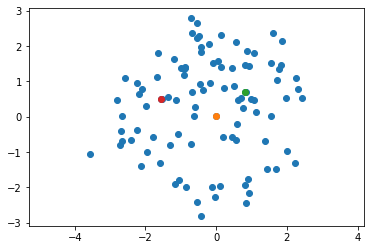

In [4]:
numberOfSims = 1 
endTime = 20 #years of simulation
ttor_masses = [['inner planet mass', 'outer planet mass','seed']]
BIGinitial = tiempo.time()
for a in range(numberOfSims):
    print("Beginning seed {}.".format(a))
    sim = generatettor(simulation = ttor, seed =a, asteroidnumber = 100)
    quickcollect2(n=2, Ti = 0 * tau, Tf=endTime * tau, stepnumber = 10)
    print("Ending seed {}.\n".format(a))
    ps = sim.particles
    pre_list = [ps[1].m, ps[2].m,a]
    ttor_masses.append(pre_list)
BIGfinal = tiempo.time()
totaltime = BIGfinal - BIGinitial
print("That in total took {} seconds ({} minutes).".format(int(totaltime), \
                                                           round(totaltime/60,2)))
print(ttor_masses)
print("There are {} particles remaining.".format(sim.N))
#ding()

Beginning seed 0.
| 0.0 time = 0.0 years | 1003 particles | 0 step number |
| 0.0 second | 0.0 minutes.

| 139.62634015954637 time = 22.222222222222225 years | 952 particles | 1 step number |
| 180.3 second | 3.0 minutes.

| 279.25268031909275 time = 44.44444444444445 years | 925 particles | 2 step number |
| 308.7 second | 5.1 minutes.

| 418.8790204786391 time = 66.66666666666667 years | 903 particles | 3 step number |
| 443.1 second | 7.4 minutes.

| 558.5053606381855 time = 88.8888888888889 years | 878 particles | 4 step number |
| 577.5 second | 9.6 minutes.

| 698.1317007977318 time = 111.11111111111111 years | 857 particles | 5 step number |
| 702.4 second | 11.7 minutes.

| 837.7580409572782 time = 133.33333333333334 years | 835 particles | 6 step number |
| 820.4 second | 13.7 minutes.

| 977.3843811168247 time = 155.55555555555557 years | 815 particles | 7 step number |
| 923.9 second | 15.4 minutes.

| 1117.010721276371 time = 177.7777777777778 years | 799 particles | 8 step

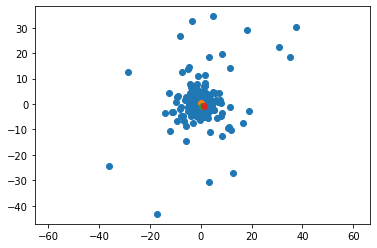

In [28]:
#running again
numberOfSims = 1 
endTime = 200 #years of simulation
ttor_masses = [['inner planet mass', 'outer planet mass','seed']]
BIGinitial = tiempo.time()
for a in range(numberOfSims):
    print("Beginning seed {}.".format(a))
    sim = generatettor(simulation = ttor, seed =a, asteroidnumber = 1000)
    quickcollect2(n=2, Ti = 0 * tau, Tf=endTime * tau, stepnumber = 10)
    print("Ending seed {}.\n".format(a))
    ps = sim.particles
    pre_list = [ps[1].m, ps[2].m,a]
    ttor_masses.append(pre_list)
BIGfinal = tiempo.time()
totaltime = BIGfinal - BIGinitial
print("That in total took {} seconds ({} minutes).".format(int(totaltime), \
                                                           round(totaltime/60,2)))
print(ttor_masses)
print("There are {} particles remaining.".format(sim.N))
#ding()

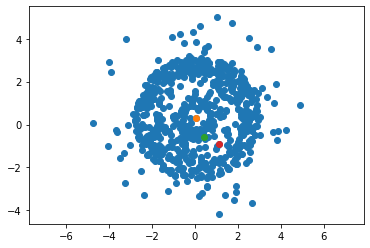

In [14]:
def remove(AU, sim = sim):
    for i in reversed(range(sim.N)):
        ps = sim.particles
        if np.linalg.norm(np.array(ps[i].xyz)-np.array(ps[0].xyz)) > AU:
            sim.remove(i)
remove(5,sim)
quickplot(sim)

| 0.0 time = 0.0 years | 1003 particles | 0 step number |
| 0.0 second | 0.0 minutes.

| 139.62634015954637 time = 22.222222222222225 years | 943 particles | 1 step number |
| 197.0 second | 3.3 minutes.

| 279.25268031909275 time = 44.44444444444445 years | 911 particles | 2 step number |
| 337.4 second | 5.6 minutes.

| 418.8790204786391 time = 66.66666666666667 years | 895 particles | 3 step number |
| 468.7 second | 7.8 minutes.

| 558.5053606381855 time = 88.8888888888889 years | 871 particles | 4 step number |
| 625.8 second | 10.4 minutes.

| 698.1317007977318 time = 111.11111111111111 years | 848 particles | 5 step number |
| 779.3 second | 13.0 minutes.

| 837.7580409572782 time = 133.33333333333334 years | 835 particles | 6 step number |
| 920.5 second | 15.3 minutes.

| 977.3843811168247 time = 155.55555555555557 years | 816 particles | 7 step number |
| 1067.7 second | 17.8 minutes.

| 1117.010721276371 time = 177.7777777777778 years | 802 particles | 8 step number |
| 1267

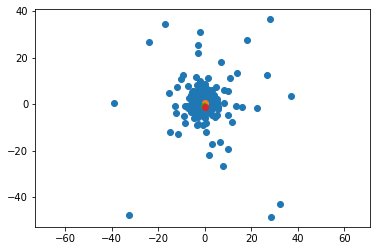

In [15]:
sim = generatettor(simulation = ttor, seed =1, asteroidnumber = 1000)
quickcollect2(n=2, Ti = 0 * tau, Tf=200 * tau, stepnumber = 10)

In [16]:
print(sim.particles[1].m)
print(sim.particles[2].m)

0.002120000000000003
0.0016300000000000017


| 0.0 time = 0.0 years | 1003 particles | 0 step number |
| 0.0 second | 0.0 minutes.

| 139.62634015954637 time = 22.222222222222225 years | 948 particles | 1 step number |
| 221.4 second | 3.7 minutes.

| 279.25268031909275 time = 44.44444444444445 years | 913 particles | 2 step number |
| 355.8 second | 5.9 minutes.

| 418.8790204786391 time = 66.66666666666667 years | 883 particles | 3 step number |
| 510.7 second | 8.5 minutes.

| 558.5053606381855 time = 88.8888888888889 years | 860 particles | 4 step number |
| 678.5 second | 11.3 minutes.

| 698.1317007977318 time = 111.11111111111111 years | 836 particles | 5 step number |
| 822.8 second | 13.7 minutes.

| 837.7580409572782 time = 133.33333333333334 years | 811 particles | 6 step number |
| 959.7 second | 16.0 minutes.

| 977.3843811168247 time = 155.55555555555557 years | 790 particles | 7 step number |
| 1083.2 second | 18.1 minutes.

| 1117.010721276371 time = 177.7777777777778 years | 772 particles | 8 step number |
| 1194

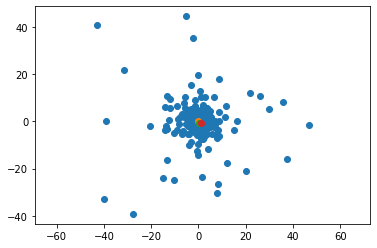

In [17]:
sim = generatettor(simulation = ttor, seed =2, asteroidnumber = 1000)
quickcollect2(n=2, Ti = 0 * tau, Tf=200 * tau, stepnumber = 10)
print(sim.particles[1].m)
print(sim.particles[2].m)

In [5]:
tttr_masses = [['inner planet mass', 'outer planet mass','seed']]
BIGinitial = tiempo.time()
for a in range(numberOfSims):
    print("Beginning seed {}.".format(a))
    sim = generatettor(simulation = tttr, seed =a, asteroidnumber = 1000)
    quickcollect2(n=2,Ti = 0,Tf=endTime * tau, stepnumber = 2)
    print("Ending seed {}.\n".format(a))
    ps = sim.particles
    pre_list = [ps[1].m, ps[2].m,a]
    tttr_masses.append(pre_list)
BIGfinal = tiempo.time()
totaltime = BIGfinal - BIGinitial
print("That in total took {} seconds ({} minutes).".format(int(totaltime), \
                                                           round(totaltime/60,2)))
print(tttr_masses)
ding()

NameError: name 'numberOfSims' is not defined

In [14]:
nor_masses = [['inner planet mass', 'outer planet mass','seed']]
BIGinitial = tiempo.time()
for a in range(numberOfSims):
    print("Beginning seed {}.".format(a))
    sim = generatettor(simulation = nor, seed =a, asteroidnumber = 1000)
    quickcollect2(n=2,Ti = 0,Tf=endTime * tau, stepnumber = 2)
    print("Ending seed {}.\n".format(a))
    ps = sim.particles
    pre_list = [ps[1].m, ps[2].m,a]
    nor_masses.append(pre_list)
BIGfinal = tiempo.time()
totaltime = BIGfinal - BIGinitial
print("That in total took {} seconds ({} minutes).".format(int(totaltime), \
                                                           round(totaltime/60,2)))
print(nor_masses)
ding()

['inner planet mass', 'outer planet mass', 'seed', [0.002190000000000003, 0.0022800000000000034, 0], [0.002190000000000003, 0.002470000000000004, 1], [0.0023200000000000035, 0.0022900000000000034, 2], [0.0024100000000000037, 0.002590000000000004, 3], [0.0022900000000000034, 0.002540000000000004, 4], [0.002440000000000004, 0.002490000000000004, 5], [0.0023800000000000036, 0.002190000000000003, 6], [0.0022400000000000033, 0.0024000000000000037, 7], [0.002450000000000004, 0.002470000000000004, 8], [0.0023900000000000037, 0.002550000000000004, 9]]


In [ ]:
def masslist_txt(masslist,filepath,sim = None, write_type = 'a'):
    """
    Saves the masslists into a formatted txt file.
    """
    
    def avg(lst):
        sum = 0
        for i in lst:
            sum += i
        return sum / len(lst)

    masslistcopy = masslist.copy() # Don't want to edit the original data
    percentlist = list()
    message = ''
    message+="Inner planet mass\tOuter planet mass\tPercent Difference\tSeed\n"
    for data in masslistcopy[1:]:
        percentdif = abs((data[0]-data[1])/data[0])*100
        roundedpercentdif = round(percentdif,2)
        percentlist.append(percentdif)
        data.insert(2,percentdif)
        for j in data:
            message += str(j)
            message +='\t'
        message +='\n'   
    message+= "\nAverage percent difference= {}.\n\n".format(avg(percentlist))
    with open(filepath,write_type) as file:
        file.write(sim+'\n')
        file.write(message)
masslist_txt(ttor_masses,'masses.txt','ttor','w')
masslist_txt(tttr_masses,'masses.txt','tttr','a')
masslist_txt(nor_masses,'masses.txt','nor','a')

In [19]:
help(np.random)

Help on package numpy.random in numpy:

NAME
    numpy.random

DESCRIPTION
    Random Number Generation
    
    Use ``default_rng()`` to create a `Generator` and call its methods.
    
    =============== =========================================================
    Generator
    --------------- ---------------------------------------------------------
    Generator       Class implementing all of the random number distributions
    default_rng     Default constructor for ``Generator``
    =============== =========================================================
    
    ============================================= ===
    BitGenerator Streams that work with Generator
    --------------------------------------------- ---
    MT19937
    PCG64
    Philox
    SFC64
    ============================================= ===
    
    ============================================= ===
    Getting entropy to initialize a BitGenerator
    --------------------------------------------- ---
    Seed

In [27]:
np.random.seed(0)
np.random.rand()

0.5488135039273248